In [0]:
#!pip install tensorflow==2.0.0

In [0]:
# Load packages

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.model_selection import cross_val_score

import nltk
import string
import re

import matplotlib.pyplot as plt

In [0]:
# Downloading additional NLTK components

#nltk.download('wordnet')

In [4]:
# Load dataset

from google.colab import drive 
drive.mount('/content/gdrive')
df_url = './gdrive/My Drive/Colab Notebooks/Consumer Complaints/Consumer_Complaints.csv'

df = pd.read_csv(df_url)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer Complaint,Company Public Response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date Sent to Company,Company Response to Consumer,Timely response?,Consumer disputed?,Complaint ID,Unnamed: 18
0,03-12-2014,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,M&T BANK CORPORATION,MI,48382,NaN,NaN,Referral,03/17/2014,Closed with explanation,Yes,No,759217,NaN
1,10-01-2016,Credit reporting,NaN,Incorrect information on credit report,Account status,I have outdated information on my credit repor...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AL,352XX,NaN,Consent provided,Web,10-05-2016,Closed with explanation,Yes,No,2141773,NaN
2,10/17/2016,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,I purchased a new car on XXXX XXXX. The car de...,NaN,"CITIZENS FINANCIAL GROUP, INC.",PA,177XX,Older American,Consent provided,Web,10/20/2016,Closed with explanation,Yes,No,2163100,NaN
3,06-08-2014,Credit card,NaN,Bankruptcy,NaN,NaN,NaN,AMERICAN EXPRESS COMPANY,ID,83854,Older American,NaN,Web,06-10-2014,Closed with explanation,Yes,Yes,885638,NaN
4,09/13/2014,Debt collection,Credit card,Communication tactics,Frequent or repeated calls,NaN,NaN,"CITIBANK, N.A.",VA,23233,NaN,NaN,Web,09/13/2014,Closed with explanation,Yes,Yes,1027760,NaN


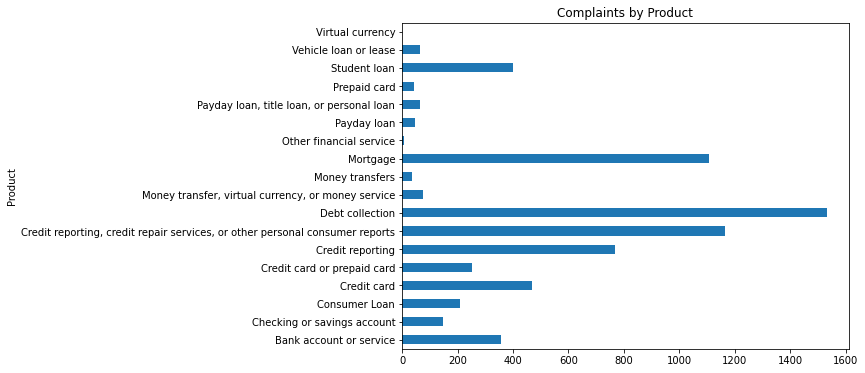

In [19]:
# Plotting the complaints by product

fig = plt.figure(figsize=(8,6))
df.groupby('Product')['Consumer Complaint'].count().plot.barh(ylim=0)
plt.title('Complaints by Product')
plt.show()

In [7]:
df.shape

(1025010, 19)

In [8]:
# Reducing the dataset size

drop_indices = np.random.choice(df.index, 1000000, replace=False)
df = df.drop(drop_indices)
df.shape

(25010, 19)

In [9]:
# Dropping unnecessary columns and empty rows and adding a category column

df = df[['Product', 'Consumer Complaint']]
df = df[pd.notnull(df['Consumer Complaint'])]
df['Complaint Category'] = df['Product'].factorize()[0]

df.head()

,Product,Consumer Complaint,Complaint Category
202,Mortgage,We are in a hardship and received a letter reg...,0
580,Debt collection,Central Financial Control did not give proper ...,1
1306,Debt collection,"This debt is from a residence of 4 years ago, ...",1
1410,Debt collection,I reached a settlement with the collection age...,1
1530,Mortgage,On XX/XX/XXXX I contacted the B of A because I...,0


In [10]:
# Creating new dataframes to store complaint categories and ids for them

complaint_category_df = df[['Product', 'Complaint Category']].drop_duplicates().sort_values('Complaint Category')

# Dictionary for category -> id
complaint_category_ids = dict(complaint_category_df.values)

# Dictionary for id -> category
complaint_categories = dict(complaint_category_df[['Complaint Category', 'Product']].values)

complaint_category_df

,Product,Complaint Category
202,Mortgage,0
580,Debt collection,1
1572,Credit card,2
3066,Bank account or service,3
3817,Credit reporting,4
5556,Student loan,5
8115,Consumer Loan,6
17485,Prepaid card,7
20245,Payday loan,8
23049,Money transfers,9


In [11]:
# Preprocessing the text

lemmatizer = nltk.stem.WordNetLemmatizer() 
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

def sentence_clean(sentence):
  sentence = re.sub('[^a-z\s]', '', sentence.lower())
  word_list = tokenizer.tokenize(sentence)
  lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
  return lemmatized_output

df['Consumer Complaint'] = df['Consumer Complaint'].apply(sentence_clean)
df.head()

,Product,Consumer Complaint,Complaint Category
202,Mortgage,we are in a hardship and received a letter reg...,0
580,Debt collection,central financial control did not give proper ...,1
1306,Debt collection,this debt is from a residence of year ago we w...,1
1410,Debt collection,i reached a settlement with the collection age...,1
1530,Mortgage,on xxxxxxxx i contacted the b of a because i a...,0


In [12]:
# Computing term frequencies

tf_idf_vectorizer = TfidfVectorizer(use_idf=True, stop_words='english')
tf_idf = tf_idf_vectorizer.fit_transform(df['Consumer Complaint'])
tf_idf_normalised = normalize(tf_idf)
features = tf_idf_normalised.toarray()

pd.DataFrame(features, columns=tf_idf_vectorizer.get_feature_names()).head()

,aa,aaa,aaddress,aadvantage,aaec,aafes,aan,aapplication,aargon,aarp,ab,aba,aback,abandon,abandoned,abandoning,abandonment,abarouting,abatement,abbreviated,abbreviati,abd,abdication,abetting,abhorrent,abide,abided,abiding,ability,abilitytobenefit,abilitytorepay,able,abled,abnormal,abo,aboard,aboutxxxxxxxx,abouv,abovementioned,abovereferenced,...,yield,yielded,ym,yment,yo,york,yorkxxxx,youand,youconsumer,youi,youll,young,younger,youngestdaughter,youonce,youre,yourknowledgeable,yousincerelyxxxx,youthis,youtube,youve,youxxxx,ypeclosed,ypu,yr,yrshistory,yrswhy,ystem,ytd,ze,zealously,zero,zeroed,zhowimg,zi,zip,zombie,zone,zoning,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


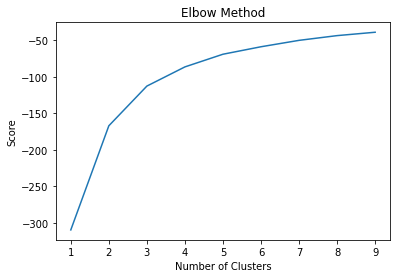

In [13]:
# Identifying number of clusters to choose

sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(features)

number_clusters = range(1, 10)

kmeans = [KMeans(n_clusters=i, max_iter = 600) for i in number_clusters]
score = [kmeans[i].fit(Y_sklearn).score(Y_sklearn) for i in range(len(kmeans))]

plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

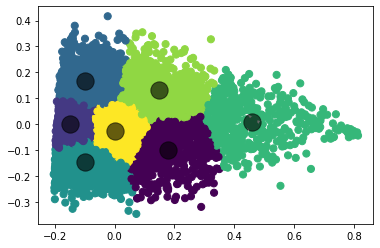

In [14]:
# Performing K-means clustering

kmeans = KMeans(n_clusters=7, max_iter=600, algorithm = 'auto')
fitted = kmeans.fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)

plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=prediction, s=50, cmap='viridis')

centers = fitted.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=300, alpha=0.6)

In [0]:
# Printing top features in each cluster

def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label)
        x_means = np.mean(tf_idf_array[id_temp], axis = 0)
        sorted_means = np.argsort(x_means)[::-1][:n_feats]
        features = tf_idf_vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

dfs = get_top_features_cluster(features, prediction, 15)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


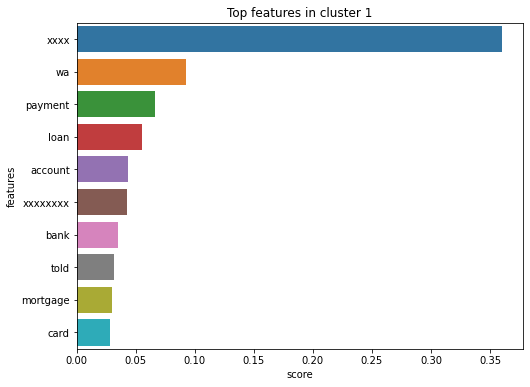

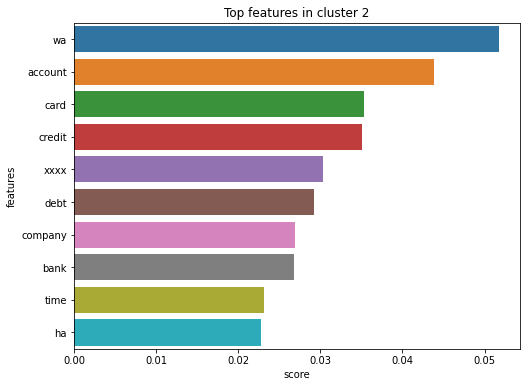

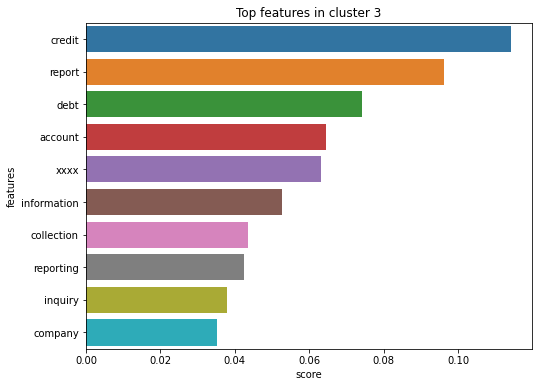

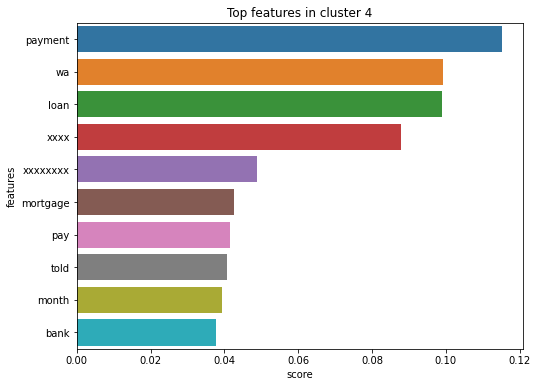

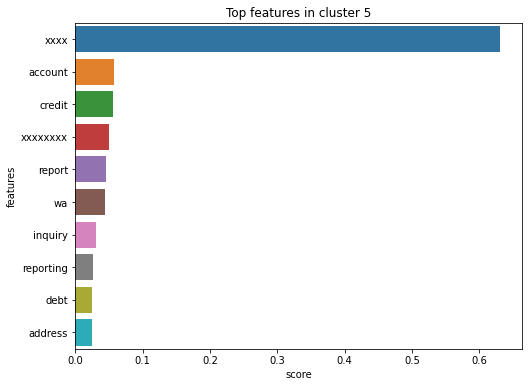

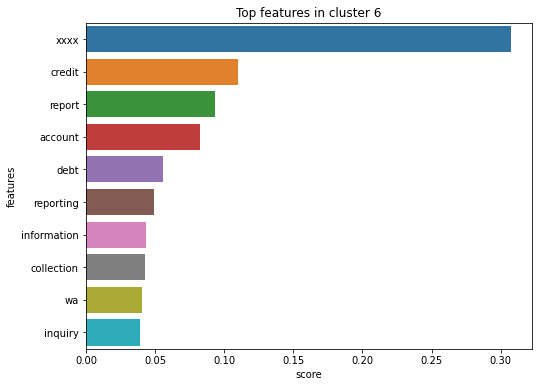

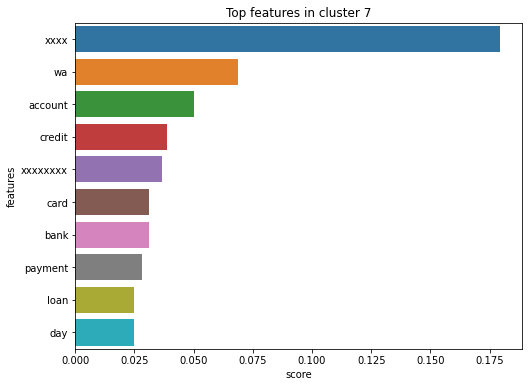

In [16]:
# Plotting features in cluster in each cluster

import seaborn as sns

for i in range(7):
  plt.figure(figsize=(8,6))
  sns.barplot(x = 'score', y = 'features', orient = 'h', data = dfs[i][:10])
  plt.title('Top features in cluster {}'.format(i+1))
  plt.show()